# Part 4b - exploring NLP products

### As a reminder, I've extracted the lyrics of every Beatles song and performed sentiment analysis on them using several different methods. 

## I started off by submitting the lyrics to several purpose-built sentiment scoring algorithms, listed below. These were created in **'Part 4 sentiment analysis'** These include the following methods/values: 

0. The Spotify dataset I build from the API provides a 'Valence' score for each song that considers **not only lyrics but also the notes of music.** I'm using this as the standard for comparison since Spotify is... well... Spotify. 

1. Bag of words approach - VADER (Valence Aware Dictionary and sEntiment Reasoner) using 'vader_lexicon' from the Natural Language Toolkit Python package. This is a "conventional" approach to sentiment analysis. The values generated by this model are: Vaders_neg	Vaders_neu	Vaders_pos	Vaders_compound. I will be focusing on **Vaders_compound**


2. Roberta is a pretrained BERT model I found on Huggingface.  The Roberta Pretrained Model is trained on a large corpus of data. Transformer model accounts for the words but also **the context related to other words.** 
The values generated by this model are:  'roberta_neg', 'roberta_neu', and 'roberta_pos'

3. Huggingface 'Pipeline' - Huggingface will select a pretrained model for me by itself. This is a black-box - more or less - but _incredibly_  easy to implement, I just set one parameter, sent_pipeline = pipeline("sentiment-analysis") and pointed to my corpus of 'lyrics'. This label generates values called sentiment_label and **sentiment_score**.

4. I tried a highly tuned model ("amanda-cristina/finetuning-sentiment-model-4500-lyrics"), also by way of Huggingface that is trained specifically on song lyrics. It returns a labeled value called **'FinetunedSentiment'** that unfortunately only returns a polarity logit assignment 'positive' or 'negative'. I wish it contained more variance to analyze.  

5. DistilBERT was developed and introduced by the team at Hugging Face. It's part of their Transformers library. I gave this one a shot too. It returned **distilbertsentiment**

## After going through several purpose-build sentiment models, I decided to use the OpenAI API to task two GPT models (text-davinci-003' and'gpt-4') to summarize the lyrics of each song and generate a valence value. This work was done in **'part 4a add GPT summaries to NLP.ipynb'**

6. **'text-davinci-003'** and 

7. **'GPT4_summary'** provide summaries of each song's lyrics. The difference between the two models is remarkable! 

8. **'GPT-4_valence_score'** is a valence score provides by GPT-4.


In [69]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

df = pd.read_pickle('BeatlesSongsNLPwithGPT.pkl')

print(df.head())


   Id            SongKey                 song                     songwriters  \
0   0  acrosstheuniverse  Across the Universe                Lennon McCartney   
1   1       actnaturally        Act Naturally  Johnny Russell Voni Morrison †   
2   2      allivegottodo   All I've Got to Do                Lennon McCartney   
3   3        allmyloving        All My Loving                Lennon McCartney   
4   4     alltogethernow     All Together Now                Lennon McCartney   

               lead_vocals  year  cover                    Era  \
0                   Lennon  1969      0  Group of Solo Artists   
1                    Starr  1965      1            Beatlemania   
2                   Lennon  1963      0            Beatlemania   
3                McCartney  1963      0            Beatlemania   
4  McCartney (with Lennon)  1969      0  Group of Solo Artists   

  first_release_date  max_key  mode  avg_danceability  avg_energy  \
0         1970-05-08      2.0   1.0          0.

In [70]:
df.columns

Index(['Id', 'SongKey', 'song', 'songwriters', 'lead_vocals', 'year', 'cover',
       'Era', 'first_release_date', 'max_key', 'mode', 'avg_danceability',
       'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
       'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo',
       'avg_duration_ms', 'avg_time_signature', 'Song_y', 'lyrics',
       'avg_popularity', 'core_catalogue_releases', 'Canonical_album',
       'first_vocalist', 'Paul_Song', 'John_Song', 'George_Song', 'Ringo_Song',
       'popularity', 'BB_name', 'BB_artist', 'BB_debut_date',
       'BB_peak_position', 'BB_peak_date', 'BB_weeks_on_chart',
       'RollingStonePosition', 'RobSegment', 'LauraSegment', 'EmilySegment',
       'OliviaSegment', 'BrianSegment', 'JackieSegment', 'vader_neg',
       'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos', 'Pipeline_sentiment_label',
       'Pipeline_sentiment_score', 'FinetunedSentiment', 'distilbertsent

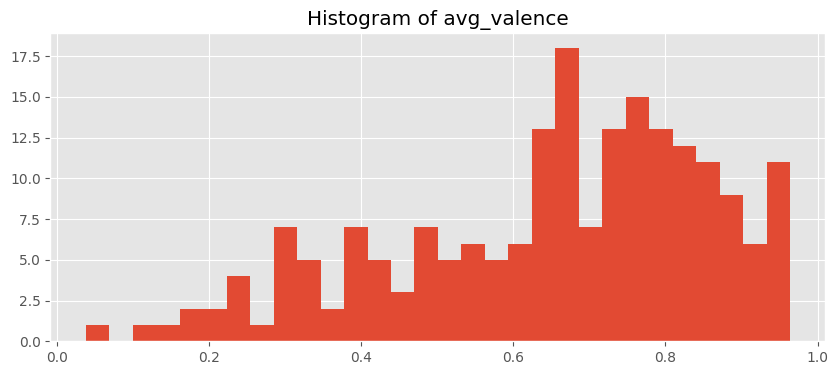

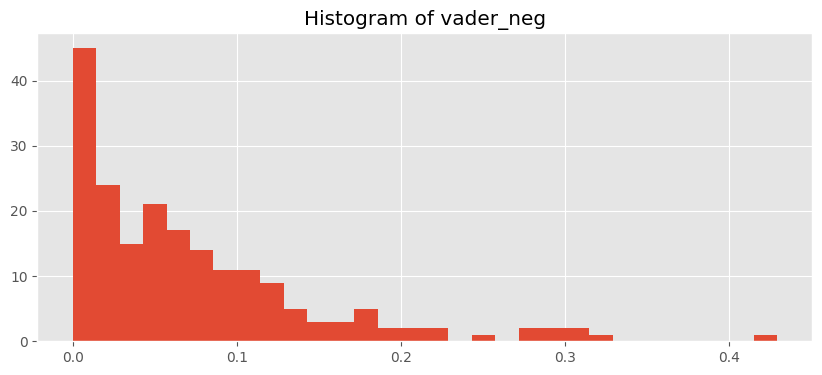

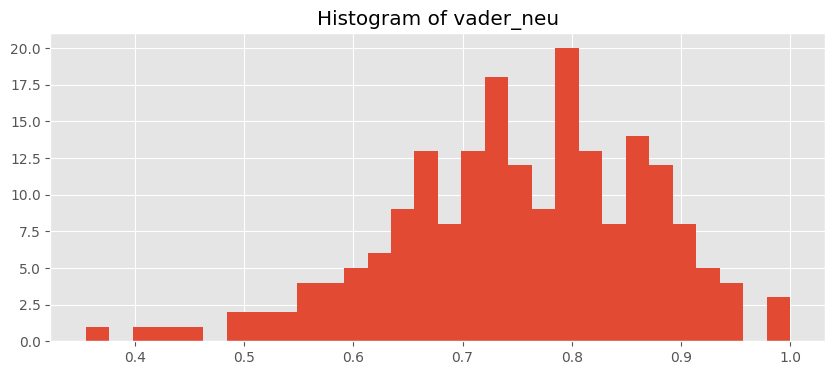

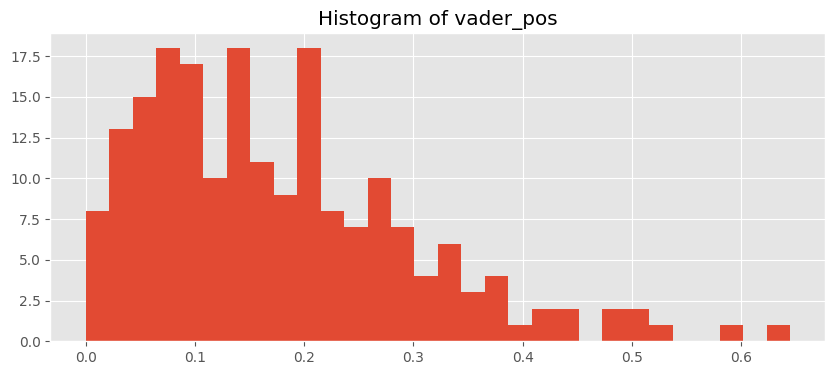

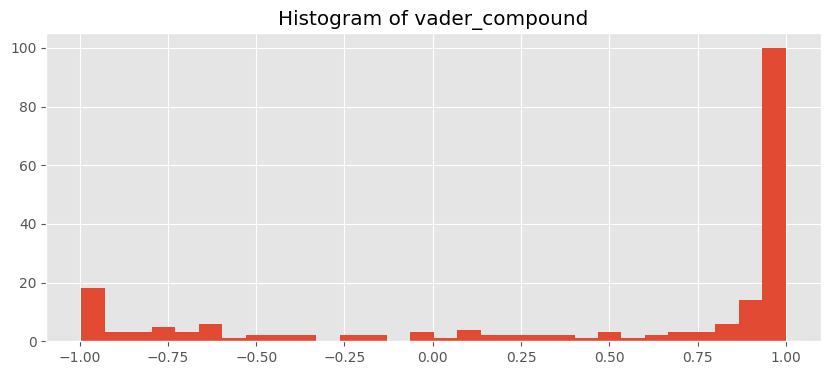

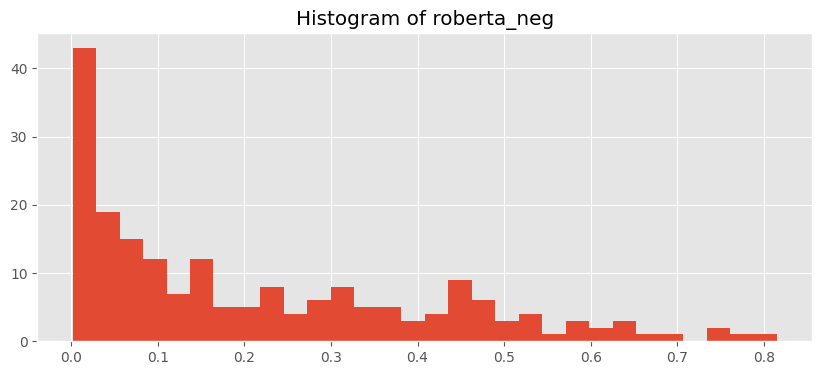

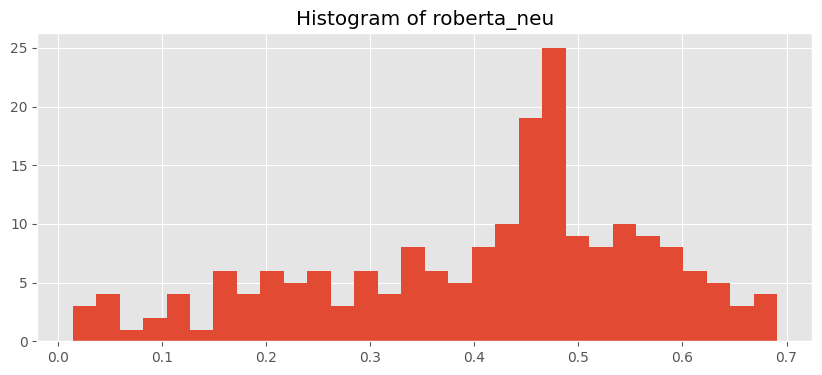

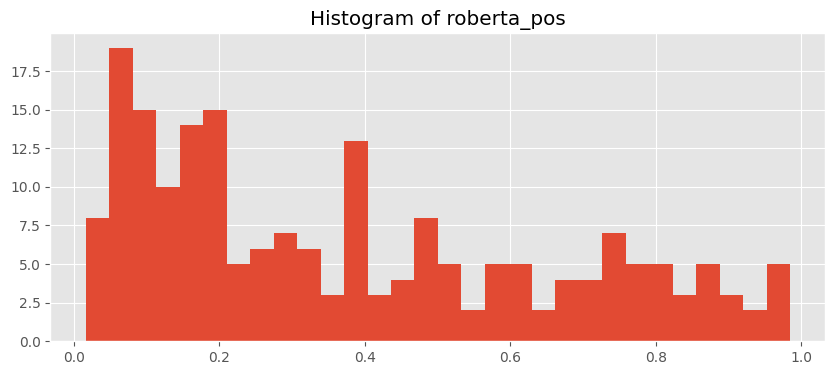

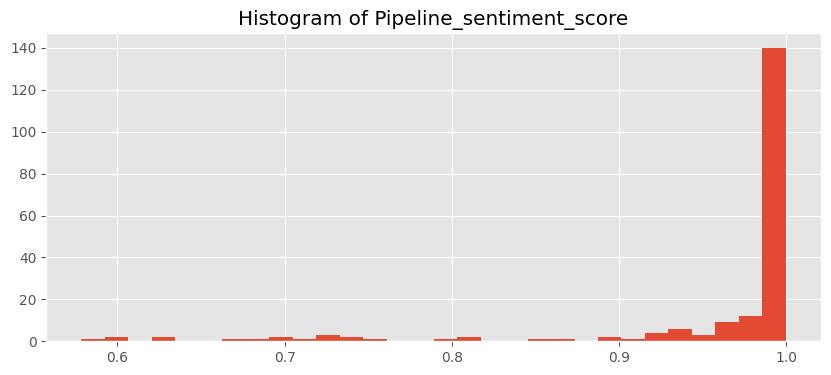

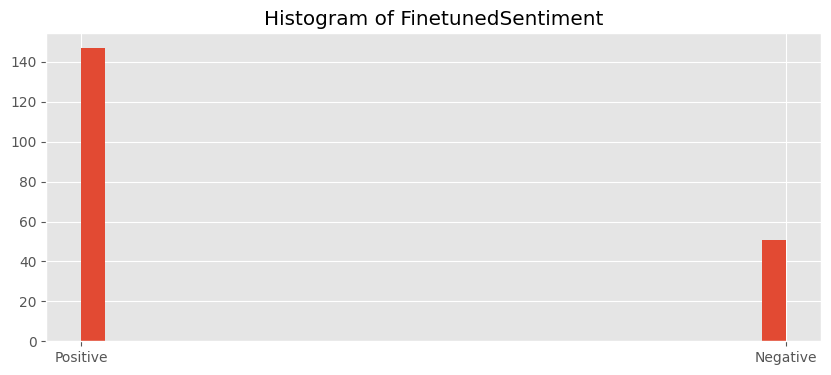

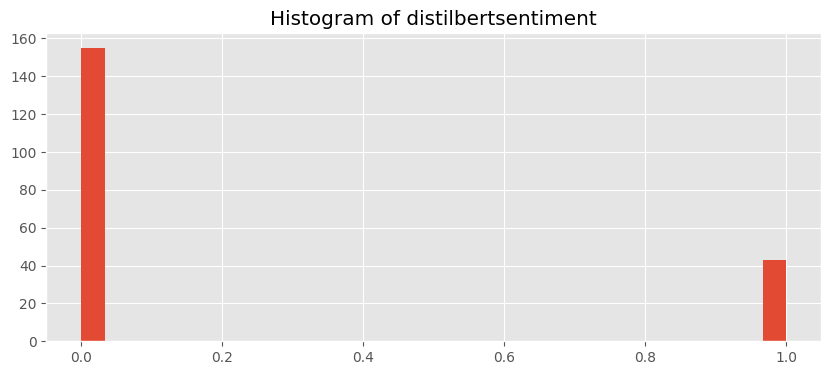

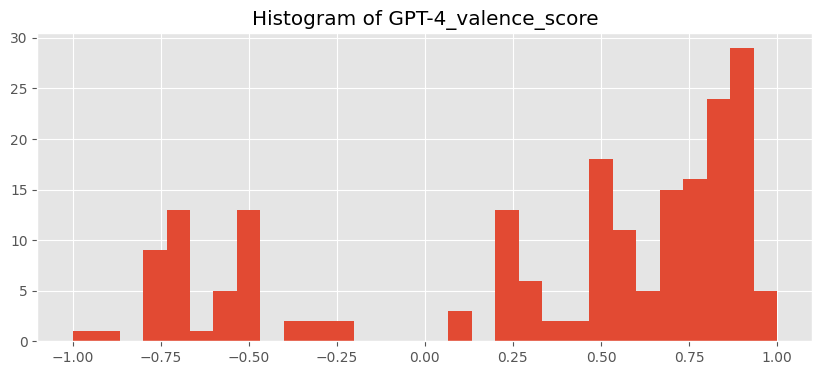

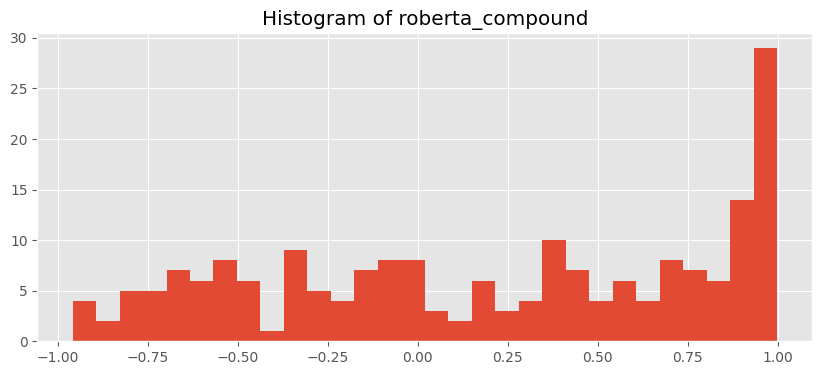

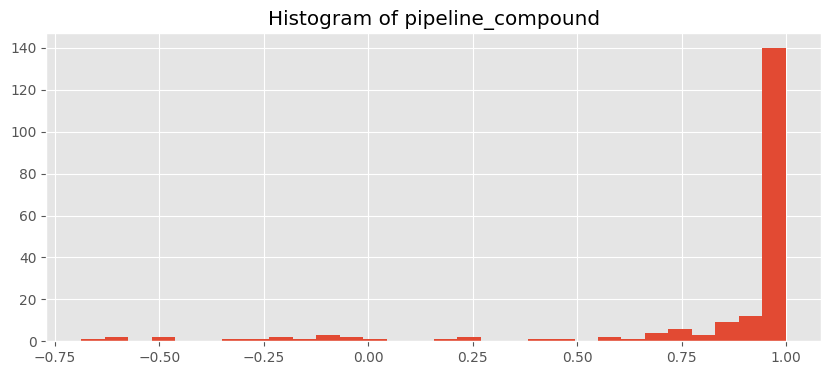

In [71]:
## Look at the distributions of Numeric Valence scores 


for col in ['avg_valence', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos', 'Pipeline_sentiment_score', 'FinetunedSentiment', 'distilbertsentiment', 'GPT-4_valence_score']:
    plt.figure(figsize=(10,4))
    plt.hist(df[col].dropna(), bins=30)  # dropna to avoid error if there are NaNs
    plt.title(f'Histogram of {col}')
    plt.show()


## 'avg_valence' from Sppotify ranges from 0 - 1
# 'vader_neg', 'vader_neu' and 'vader_pos' all vary between 0 - 1. 
#     These are combined into 'vader_compound' varies between -1 and 1. I will use this for the Bag-of-Words model score going forward.
#     This has a severe left-handed skew 
# 
# 'roberta_neg',  'roberta_neu', 'roberta_pos' all vary between 0 - 1.  I will scale these to run from -1 to 1. 


import math

def calculate_compound_score(roberta_neg, roberta_neu, roberta_pos):
    compound_score = (roberta_pos - roberta_neg) / math.sqrt(roberta_pos**2 + roberta_neu**2 + roberta_neg**2)
    return compound_score

df['roberta_compound'] = df.apply(lambda x: calculate_compound_score(x['roberta_neg'], x['roberta_neu'], x['roberta_pos']), axis=1)


# 
# 'Pipeline_sentiment_score' varies from 0.5 to 1. I will scale these to run from -1 to 1.

def scale_value(old_value, old_min=0.5, old_max=1, new_min=-1, new_max=1):
    new_value = (old_value - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
    return new_value

df['pipeline_compound'] = df['Pipeline_sentiment_score'].apply(scale_value)

# 'FinetunedSentiment' and 'distilbertsentiment' are both binary 1 or 0. There's no variance to analyze, so I will drop these from further analsyis.
# 
# 'GPT-4_valence_score' varies between -1 and 1, with a slight left-handed skew. I will use this for the GPT-4 model score going forward.



for col in ['roberta_compound', 'pipeline_compound']:
    plt.figure(figsize=(10,4))
    plt.hist(df[col].dropna(), bins=30)  # dropna to avoid error if there are NaNs
    plt.title(f'Histogram of {col}')
    plt.show()
    

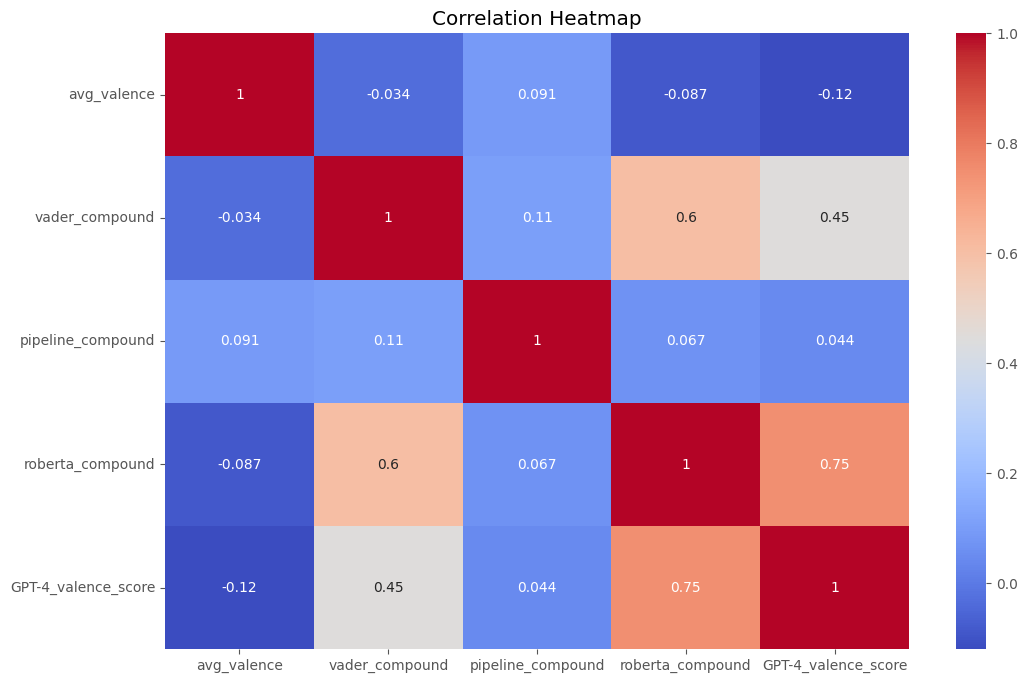

In [72]:
# Subset dataframe to include only specific columns
df_subset = df[['avg_valence', 'vader_compound', 'pipeline_compound', 'roberta_compound', 'GPT-4_valence_score']]

# Calculate correlation on the subset dataframe
correlation = df_subset.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

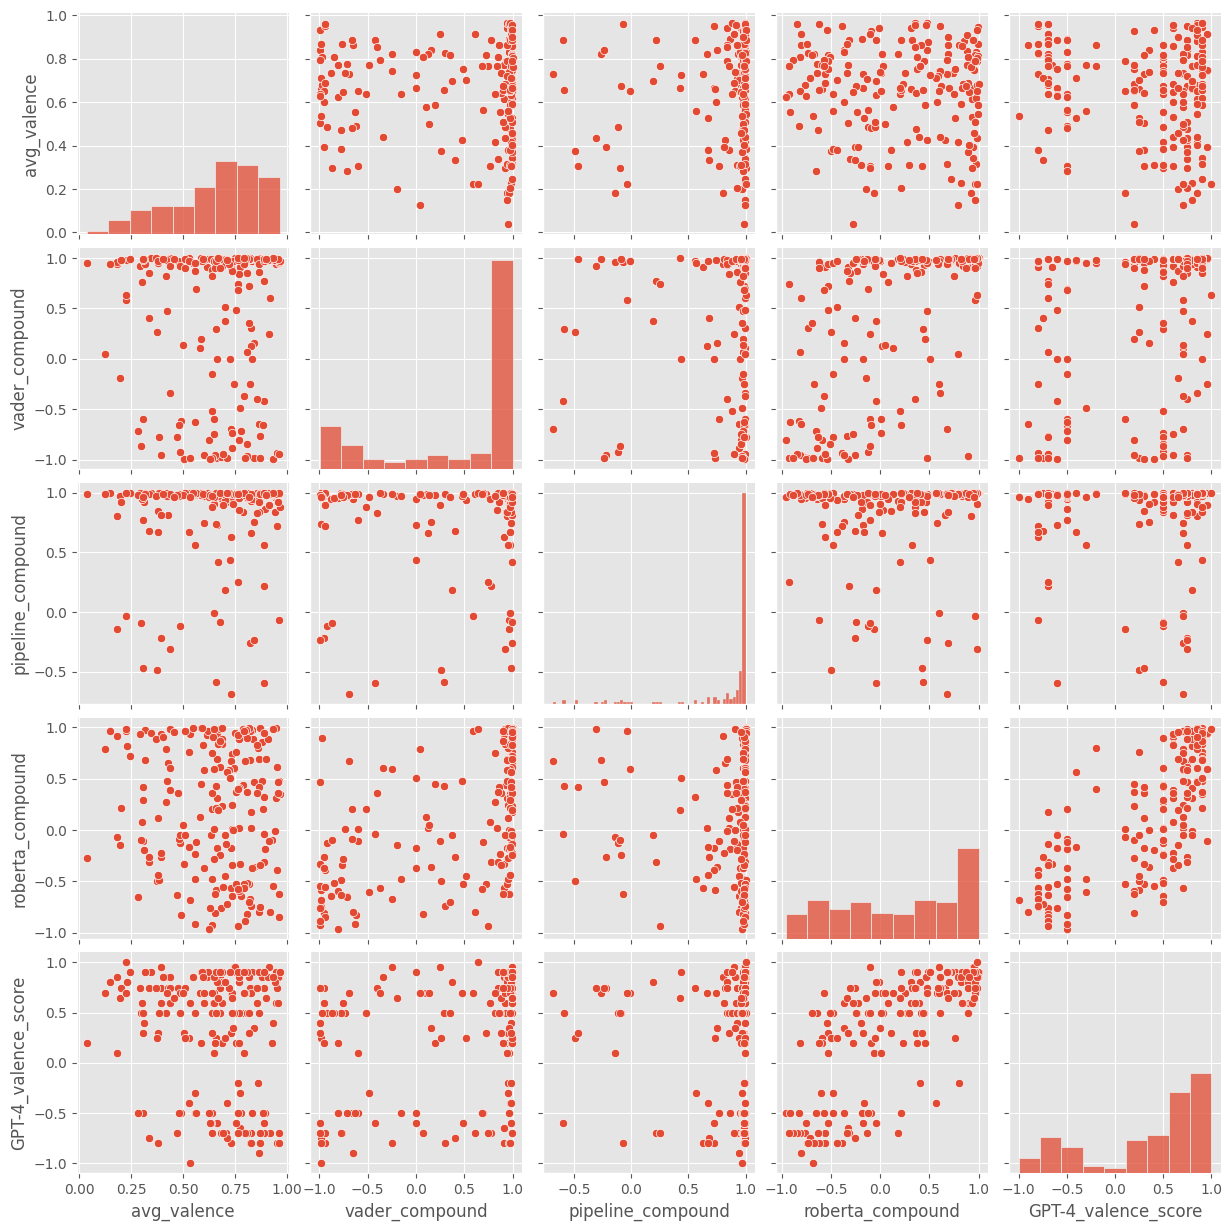

In [73]:
# Create pairplots for the high correlation subset dataframe
sns.pairplot(df_subset)
plt.show()

In [74]:

## There's a very high correlation between roberta and gpt-4 valence scores. (0.75)
## There is very high correlation between roberta and vaders. (0.60) 
## There is a moderately high correlation between vaders and gpt-4. (0.45)

## Pipeline is not very interesting.

## Split the interesting columns into quartiles to see if there are any interesting patterns

def split_into_quartiles(df, column):
    quartiles = pd.qcut(df[column], q=4, labels=False)
    return quartiles



df['Spotify_Qtile'] = split_into_quartiles(df, 'avg_valence')
df['vader_Qtile'] = split_into_quartiles(df, 'vader_compound')
df['roberta_Qtile'] = split_into_quartiles(df, 'roberta_compound')
df['GPT-4_Qtile'] = split_into_quartiles(df, 'GPT-4_valence_score')




Text(0.5, 1.0, 'Noteworthy songs where Spotify and the NLP models disagree')

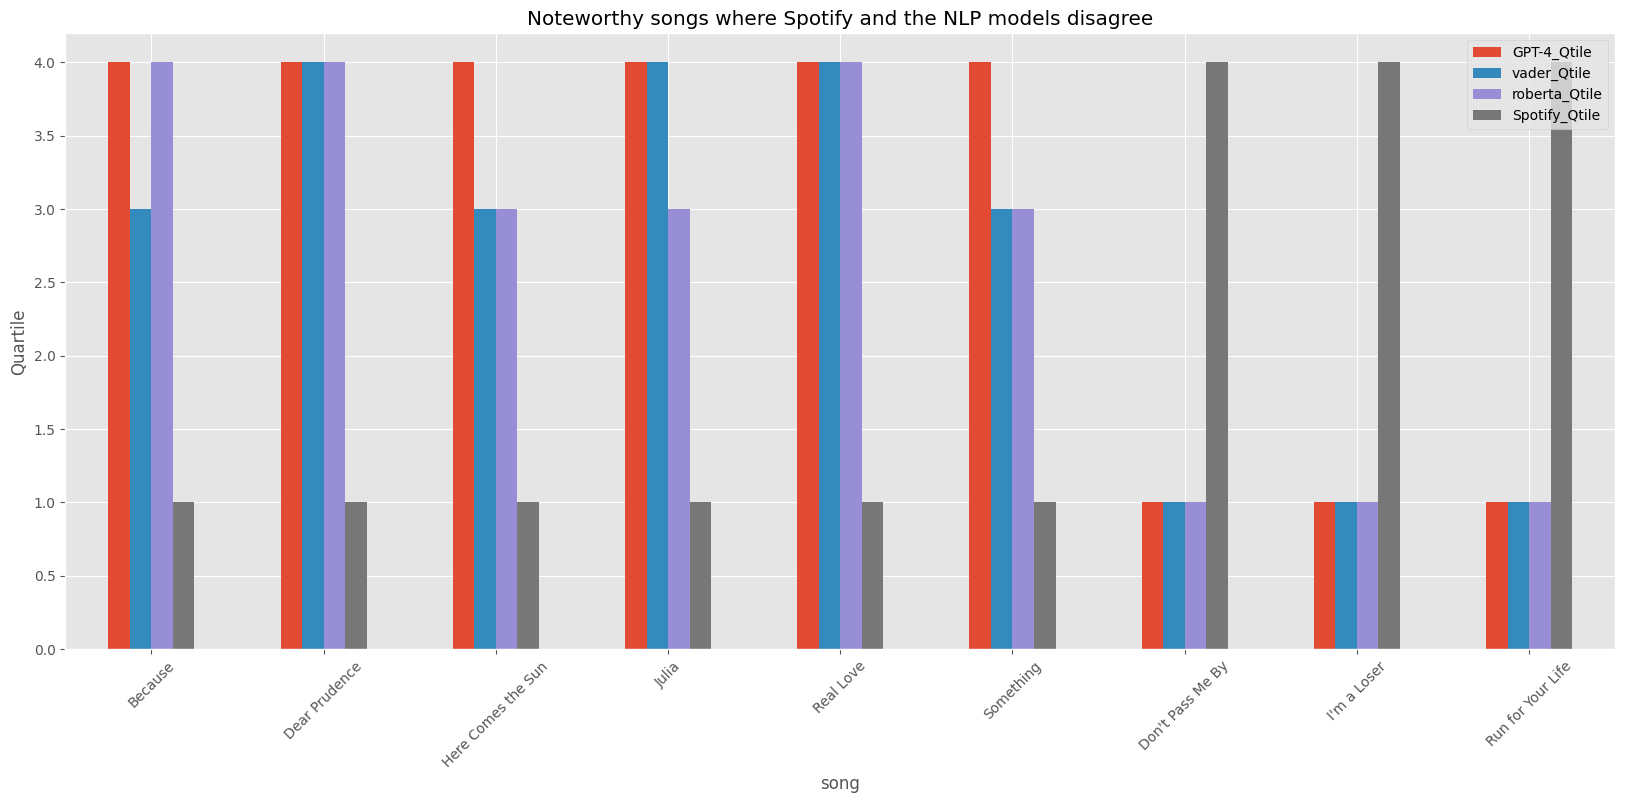

In [75]:

# Columns to include in the output
output_cols = ['song'] + quartile_cols

# Songs where any quartile score is 3 and any of the others is 0
condition_1 = df[quartile_cols].apply(lambda row: 3 in row.values and 0 in row.values, axis=1)
songs_1 = df.loc[condition_1, output_cols]

# Add 1 to each of the quartiles
songs_1[quartile_cols] = songs_1[quartile_cols].applymap(lambda x: x + 1)


# Define the list of songs in the desired order
Noteworthy_mismatches = ['Because', 'Dear Prudence', 'Here Comes the Sun', 'Julia', 'Real Love', 'Something', "Don't Pass Me By", "I'm a Loser", 'Run for Your Life']

# Columns to include in the output
output_cols = ['song'] + quartile_cols

# Songs where any quartile score is 3 and any of the others is 0
condition_1 = df[quartile_cols].apply(lambda row: 3 in row.values and 0 in row.values, axis=1)
songs_1 = df.loc[condition_1, output_cols]

# Add 1 to each of the quartiles
songs_1[quartile_cols] = songs_1[quartile_cols].applymap(lambda x: x + 1)

# Set index to 'song' column
songs_1.set_index('song', inplace=True)

# Select songs in Noteworthy_mismatches in the specified order
ordered_songs = songs_1.loc[Noteworthy_mismatches]

# Plot bar graph and get Axes object
ax = ordered_songs.plot.bar(figsize=(20, 8))

# Rotate x-axis labels, set y-axis label, and set title
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Quartile')
ax.set_title("Noteworthy songs where Spotify and the NLP models disagree")




# General observations
### Spotify uses both the words in the lyrics and more importantly, the music itself, to determine valence. The other three models just use the words

### The NLP models agree that Because, Dear Produnce, Here Comes the Sun, Julia, Real Love, Something are happy songs. 
### But Spotify thinks they are sad songs.

### I agree with they NLP models! Because, Dear Prudence, Here Comes the Sun, Julia, Real Love are all about love, happiness and discovery. 
### Sinatra called 'Something' the most beautiful love song ever written. So there's that!


### Spotify thinks Don't Pass Me By, I'm a Loser, Run for Your Life are happy songs, but the NLP models think they are sad songs.
### Again, I agree with NLP models. Don't Pass Me By is a Ringo country song. In Run For Your Life, John threatens to kill his girlfriend if she cheats. I'm A Loser - 'nuff said!



In [81]:
#!pip install tabulate
#!pip install textwrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
from tabulate import tabulate
import textwrap


# Define the columns to retrieve
retrieve_cols = ['song', 'lyrics', 'GPT4_summary']

# Define the noteworthy songs
Noteworthy_mismatches = ['Because', 'Dear Prudence', 'Here Comes the Sun', 'Julia', 'Real Love', 'Something', "Don't Pass Me By", "I'm a Loser", 'Run for Your Life']

# Filter DataFrame to only include songs in Noteworthy_mismatches
song_details = df[df['song'].isin(Noteworthy_mismatches)][retrieve_cols]

# Apply text wrapping to the 'lyrics' and 'GPT4_summary' columns
song_details['lyrics'] = song_details['lyrics'].apply(lambda x: "\n".join(textwrap.wrap(x, width=40)))
song_details['GPT4_summary'] = song_details['GPT4_summary'].apply(lambda x: "\n".join(textwrap.wrap(x, width=40)))

# Print the song details
for i, row in song_details.iterrows():
    print(f"Song: {row['song']}")
    print(f"Lyrics: {row['lyrics']}")
    print(f"GPT4 Summary: {row['GPT4_summary']}")
    print("\n---\n")

Song: Because
Lyrics: Because the world is round it turns me
on Because the world is
round...aaaaaahhhhhh  Because the wind
is high it blows my mind Because the
wind is high......aaaaaaaahhhh  Love is
all, love is new Love is all, love is
you  Because the sky is blue, it makes
me cry Because the sky is
blue.......aaaaaaaahhhh
Aaaaahhhhhhhhhh....
GPT4 Summary: The lyrics express a deep appreciation
for the natural world, it's circular
shape, the blowing wind, the blue sky,
all of which are causing strong
emotional reactions in the singer. They
also express the all-encompassing and
renewing nature of love, equating it
with someone in particular. Overall,
these lyrics evoke a powerful,
emotional, and positive response.

---

Song: Dear Prudence
Lyrics: Dear Prudence, won't you come out to
play Dear Prudence, greet the brand new
day The sun is up, the sky is blue It's
beautiful and so are you Dear Prudence
won't you come out and play  Dear
Prudence open up your eyes Dear Prudence
see the s

In [84]:
##This doesn't display well in Jupyter. I will export to a text file and display in a PowerPoint slide.